# Orbits in Cartesian Coordinates - Tiberius Berndsen
In this notebook I will do parts A, B, and C of problem 2. 

In [21]:
%matplotlib inline

In [22]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

# Part A

When dealing with the orbit equation the most common form one uses is the following.

$\begin{equation}
\ddot r - r \dot\phi^2 = - \frac{GMm}{r^2}
\end{equation}$

However, this is most useful for dealing with a 2-body problem in an analytical manner. When wanting to deal with objects in motion, the better way to do it numerically is via Cartesian coordinates. While a pain in hand done problems, they are of good use in the way python solves odes. Additionally they allow one to avoid having to take into account the centrifugal force. So let us define our z-vector (we will use z since we are already using y as a coordinate) as such. The indexes will not which mass they are describing, mass 1 goes to 1, mass 2 to 2.

$ \begin{align}
z = 
\begin{pmatrix}
z_1\\
z_2\\
z_3\\
z_4\\
z_5\\
z_6\\
z_7\\
z_8
\end{pmatrix}
=
\begin{pmatrix}
x_1 \\
\dot x_1 \\
y_1 \\
\dot y_1 \\
x_2 \\
\dot x_2 \\
y_2 \\
\dot y_2 \\
\end{pmatrix}
\end{align}
$

We can easily convert by noting in this context we can have the trig relations to fully convert from polar to cartesian.

$\begin{equation}
r^2 = x^2 + y^2
\end{equation}$

$\begin{equation}
\cos\phi = \frac{x}{\sqrt{x^2 + y^2}}
\end{equation}$

$\begin{equation}
\sin\phi = \frac{y}{\sqrt{x^2 + y^2}}
\end{equation}$

By taking advantage of Newton's third law we can show that the following relations are true. 

$\begin{equation}
m_{1}\ddot x_{1} = - m_{2}\ddot x_{2} = -\frac{Gm_{1}m_{2} (x_{2} - x_{1})}{((x_2 - x_1)^2 + (y_2 - y_1)^2)^{\frac{3}{2}}}
\end{equation}$

$\begin{equation}
m_{1}\ddot y_{1} = - m_{2}\ddot y_{2} = -\frac{Gm_{1}m_{2} (y_{2} - y_{1})}{((x_2 - x_1)^2 + (y_2 - y_1)^2)^{\frac{3}{2}}}
\end{equation}$

The choice of mass 1 or mass 2 carrying the negative is arbitrary by Newton's third law as long as it is kept consistent. 

In [48]:
class CartesianOrbits():
    """
    Here we will use the equations documented above to determine what the 
    resulting motion will look like. I will use the dz/dt method to solve
    the equations numerically.
    """
    def __init__(self, m_1 = 1., m_2 = 1., G = 1.):
        self.m_1 = m_1 #Mass of oject 1: Float
        self.m_2 = m_2 #Mass of oject 2: Float
        self.G = G #Gravitational Constant: Float
        """
        Remarkably motion under gravity requires few input parameters.
        """
    def dz_dt(self, t, z):
        """
        The z-vector has 8 components in it which are organized in the 
        following manner:
        
        z[0] = x_1
        z[1] = \dot x_1
        z[2] = y_1
        z[3] = \dot y_1
        z[4] = x_2
        z[5] = \dot x_2
        z[6] = y_2
        z[7] = \dot y_2
        
        So when we do the dz/dt we should only have to plug in an equation
        into dz_dt[1], dz_dt[3], dz_dt[5], dz_dt[7]. As discussed in the
        write up above, it is arbritary which object carries the negative
        let object two carry it.
        """
        
        return [z[1], self.G * self.m_2 * (z[4] -z[0]) / ( ( (z[4] - z[0]) ** 2  + (z[6] - z[2]) ** 2) ** (1.5) ), \
                z[3], self.G * self.m_2 * (z[6] -z[2]) / ( ( (z[4] - z[0]) ** 2  + (z[6] - z[2]) ** 2) ** (1.5) ), \
                z[5], -1 * self.G * self.m_1 * (z[4] -z[0]) / ( ( (z[4] - z[0]) ** 2  + (z[6] - z[2]) ** 2) ** (1.5) ), \
                z[7], -1 * self.G * self.m_1 * (z[6] -z[2]) / ( ( (z[4] - z[0]) ** 2  + (z[6] - z[2]) ** 2) ** (1.5) )]
    
    def solve_ode(self, t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                  x_2_0, x_2_dot_0, y_2_0, y_2_dot_0, abserr=1.0e-9, relerr=1.0e-9):
        """
        Here we need 8 initial conditions x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                  x_2_0, x_2_dot_0, y_2_0, y_2_dot_0
        """
        
        z = [x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                  x_2_0, x_2_dot_0, y_2_0, y_2_dot_0] 
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_1_dot, y_1, y_1_dot, \
                  x_2, x_2_dot, y_2, y_2_dot = solution.y

        return x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot

# Part B
Now that we have code that can solve the equations of motion we can now show what the motion would look like. Specifically we want to show that if one mass if much heavier than the other (for the sake of argument let $m_{1} >> m_{2}$) and we are in the rest frame, then the problem will simply reduce to the two body problems considered in class.

In [49]:
# Again this was borrowed from the Lagrangian Pendulum notebook

def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [50]:
#This part was borrowed from the Lagrangian Pendulum Notebook

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [51]:
# Define the time for which we will solve the equations

t_start = 0. 
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end + delta_t, delta_t)

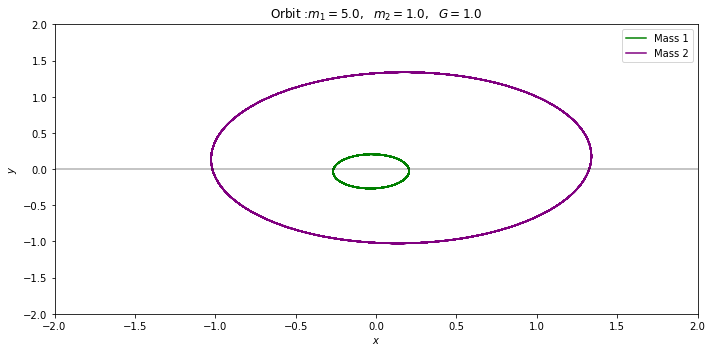

In [56]:
# Next we define what the constants are
G = 1.
m1 = 5.
m2 = 1.

orbit = CartesianOrbits(m1, m2, G)

# For this plot to be made sense of will need to a center of mass to be stationary
# Best way to do this is to first define the smaller mass first

x_2_0 = 1.
x_2_dot_0 = -1.0
y_2_0 = 1.
y_2_dot_0 = 1.

# If we let the larger mass have the opposite initial coniditions times the ratio
# between masses this will ensure that \dot R = 0

x_1_0 = - 1 * ((m2) / (m1)) * x_2_0
x_1_dot_0 = - 1 * ((m2) / (m1)) * x_2_dot_0
y_1_0 = - 1 * ((m2) / (m1)) * y_2_0
y_1_dot_0 = - 1 * ((m2) / (m1)) * y_2_dot_0

# Now when we solve these equations we will have them orbit about a barycenter
# Where the barycenter is just the center of mass

x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = orbit.solve_ode(t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                  x_2_0, x_2_dot_0, y_2_0, y_2_dot_0)

fig_orbit = plt.figure(figsize=(10,5))
ax_orbit = fig_orbit.add_subplot(1,1,1)

# Here we will plot the state space on the same graph, to show that for both the motion is not chaotic.
ax_orbit.plot(x_1, y_1, linestyle='solid', color='green', label='Mass 1')
ax_orbit.plot(x_2, y_2, linestyle='solid', color='purple', label='Mass 2')

# Make sure one picks suitable limits so you can see all of the figure
ax_orbit.set_xlim(-2., 2.)
ax_orbit.set_ylim(-2., 2.)
ax_orbit.set_xlabel('$x$')
ax_orbit.set_ylabel('$y$')
ax_orbit.set_title(f'Orbit :$ m_1 = {m1} ,\ \  m_2 = {m2}, \ \ G = {G}$')
ax_orbit.legend(loc='upper center')
ax_orbit.axhline(0., color='black', alpha=0.3)
plt.legend(loc = 'upper right')
fig_orbit.tight_layout()

So here we see two ellipses orbiting about their center of mass. Since each one is orbiting around a foci, then Kepler's laws and the results from Newton's laws of motion apply here very neatly. Now we wish to show that if $m_1 >> m_2$ is taken to its extreme, or in short.

$\begin{equation}
\frac{m_2}{m_2} \xrightarrow []{} 0
\end{equation}$

We should return the case where the larger object is essentially fixed in this frame. So for exaple the earth and the sun. So let us create a case where this is true. Now in doing so it is important that one also increases how far away the smaller object is from the larger one, or else it will simulate the object fallining into it due to the significantly higher force it is subject to.

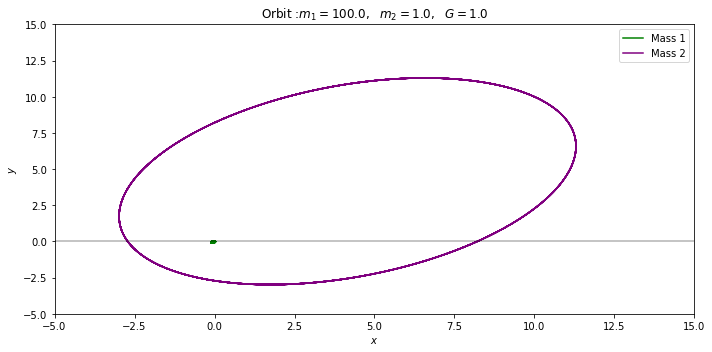

In [63]:
# Next we define what the constants are
G = 1.
m1 = 100.
m2 = 1.

orbit = CartesianOrbits(m1, m2, G)

# For this plot to be made sense of will need to a center of mass to be stationary
# Best way to do this is to first define the smaller mass first

x_2_0 = 10.
x_2_dot_0 = -1.0
y_2_0 = 10.
y_2_dot_0 = 1.0

# If we let the larger mass have the opposite initial coniditions times the ratio
# between masses this will ensure that \dot R = 0

x_1_0 = - 1 * ((m2) / (m1)) * x_2_0
x_1_dot_0 = - 1 * ((m2) / (m1)) * x_2_dot_0
y_1_0 = - 1 * ((m2) / (m1)) * y_2_0
y_1_dot_0 = - 1 * ((m2) / (m1)) * y_2_dot_0

# Now when we solve these equations we will have them orbit about a barycenter
# Where the barycenter is just the center of mass

x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = orbit.solve_ode(t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
                  x_2_0, x_2_dot_0, y_2_0, y_2_dot_0)

fig_orbit = plt.figure(figsize=(10,5))
ax_orbit = fig_orbit.add_subplot(1,1,1)

# Here we will plot the state space on the same graph, to show that for both the motion is not chaotic.
ax_orbit.plot(x_1, y_1, linestyle='solid', color='green', label='Mass 1')
ax_orbit.plot(x_2, y_2, linestyle='solid', color='purple', label='Mass 2')

# Make sure one picks suitable limits so you can see all of the figure
ax_orbit.set_xlim(-5., 15.)
ax_orbit.set_ylim(-5., 15.)
ax_orbit.set_xlabel('$x$')
ax_orbit.set_ylabel('$y$')
ax_orbit.set_title(f'Orbit :$ m_1 = {m1} ,\ \  m_2 = {m2}, \ \ G = {G}$')
ax_orbit.legend(loc='upper center')
ax_orbit.axhline(0., color='black', alpha=0.3)
plt.legend(loc = 'upper right')
fig_orbit.tight_layout()

As we can see the motion of the larger mass is reduced to effectively nothing. As a result in cases like this it is acceptable to use the idea that the reduced mass $\mu = m_2$ and there fore the center of mass is where the larger mass sits exactly